# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [1]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE


plt.ion()
%matplotlib inline

In [308]:
# Additional imports, testing rn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from pprint import pprint
import operator

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [70]:
opt = {
    'image_size': 32,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [405]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 32, 32)


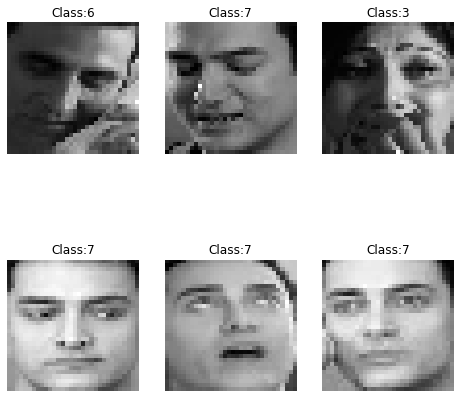

In [72]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Section: Additional Stuff that was used for prototyping initially.

In [73]:
FEATURE_COUNT = 210
SHAPE = (400, 32, 32)

In [74]:
# a = [1, 2, 3]
# print(tuple(a))

(1, 2, 3)


In [75]:
# Display 1 Image
def disply_image(img, classe, w=16, h=16):
    fig=plt.figure(figsize=(4, 4))
    
    if opt['is_grayscale']:
        plt.imshow(img , cmap='gray') 
    else:
        plt.imshow(img)
        
    plt.title("Class:{}".format(classe))
    plt.axis('off')
        
    plt.show()

### Reconstructing the image from the eigenface

In [76]:
def reconstruct_image(approximation, shape, ind):
    disply_image(X.reshape(shape)[ind,...],y[ind])

def reconstruct_images(approximation, shape, ind):
    disply_images(approximation.reshape(shape)[ind,...],y[ind], row=1, col=len(ind))
    
def compare_images_reconstructed(X, approximation, shape, ind):
    print("Original:")
    disply_images(X.reshape(shape)[ind,...],y[ind], row=1,col=len(ind))
    print("Reconstructed:")
    disply_images(approximation.reshape(shape)[ind,...],y[ind], row=1,col=len(ind))

In [96]:
# reconstruct_image(approximation, SHAPE, 123)

In [77]:
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, check_X_y

def lda_inverse_transform(lda, x):
    if lda.solver == 'lsqr':
        raise NotImplementedError("(inverse) transform not implemented for 'lsqr' "
                                  "solver (use 'svd' or 'eigen').")
    check_is_fitted(lda, ['xbar_', 'scalings_'], all_or_any=any)

    inv = np.linalg.pinv(lda.scalings_)

    x = check_array(x)
    if lda.solver == 'svd':
        x_back = np.dot(x, inv) + lda.xbar_
    elif lda.solver == 'eigen':
        x_back = np.dot(x, inv)

    return x_back


## Testing Features

### PCA

In [409]:
X_k, approximation, explained_variance = get_pca(X, FEATURE_COUNT)
print(X_k.shape)
print(y.shape)
print(approximation.shape)
print(sum(explained_variance))

(400, 210)
(400,)
(400, 1024)
0.9857240708565908


Original:


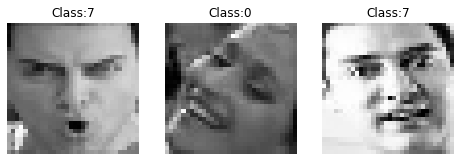

Reconstructed:


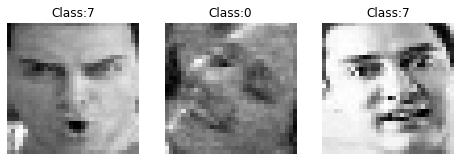

In [410]:
ind = np.random.randint(0,y.shape[0],3)
compare_images_reconstructed(X, approximation, SHAPE, ind)

### Kernel PCA

Original:


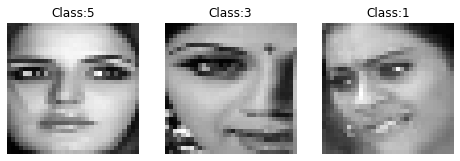

Reconstructed - linear:


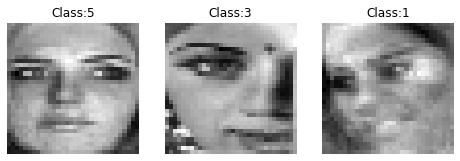

Reconstructed - poly:


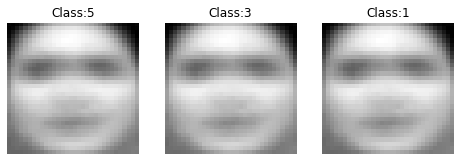

Reconstructed - rbf:


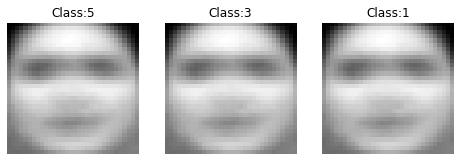

Reconstructed - sigmoid:


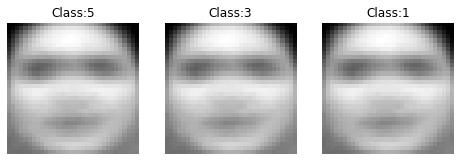

Reconstructed - cosine:


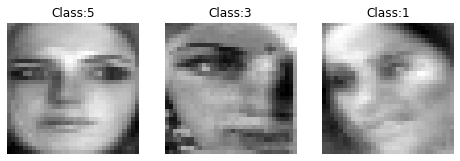

In [411]:
# ind = np.random.randint(0,y.shape[0],3)
# print("Original:")
# reconstruct_images(X, SHAPE, ind)
# for kern in ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']:
#     print("Reconstructed - {0}:".format(kern))
#     X_k, approximation = get_kernel_pca(X, FEATURE_COUNT, kernel=kern)
#     reconstruct_images(approximation, SHAPE, ind)

### LDA

/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


(400, 7)
LinearDiscriminantAnalysis(n_components=210, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
(400, 1024)
Original:


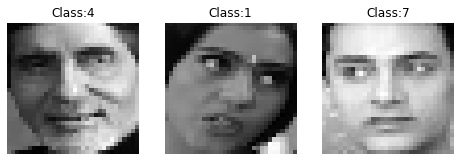

Reconstructed:


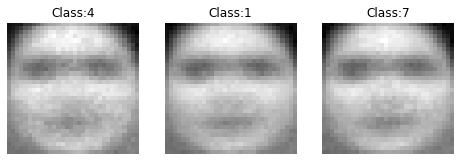

In [412]:
# X_k, lda = get_lda(X, y, FEATURE_COUNT)

# print(X_k.shape)
# print(lda)
# approximation = lda_inverse_transform(lda, X_k)
# print(approximation.shape)


# ind = np.random.randint(0,y.shape[0],3)
# compare_images_reconstructed(X, approximation, SHAPE, ind)
# #     reconstructed = pca.inverse_transform(lda.scalings_[:, i])
# #     print(reconstructed.shape)
# #     compare_images_reconstructed(X, reconstructed, ind)

# End of Extra Section

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [406]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [408]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    
    approximation = pca.inverse_transform(X_k)
    explained_variance = pca.explained_variance_ratio_
    return X_k, approximation, explained_variance

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [83]:
def get_kernel_pca(X, k, kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree, fit_inverse_transform=True)
    X_k = kpca.fit_transform(X)
    
    approximation = kpca.inverse_transform(X_k)
    return X_k, approximation

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [160]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k =lda.fit_transform(X, y)
    
    return X_k, lda

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [87]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [88]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [89]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of human face recognition. It is essentially an eigendecomposition of faces to lower dimensions, using multiple methods such as basic PCA, LDA, Fisherface, etc.

1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

**Answer**: We do not need too many features to reconstruct a person, per se. However, to be absolutely certain, it would be correct to claim that a representation that has about 95% of the features of the original image should be satisfactory to reconstruct a person in this three databases. 

Going with this logic, we attempt to calculate the number of features needed by a basic PCA eigenface representation to get this 95%. The results are:
- IMFDB: **120 features**
- Yale face database: **60 features**
- IIIT CFW: **310 features**

*Graphs are shown below*

In [91]:
# Create a scatter plot  
# eg.
# fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)

Using the ./dataset/IMFDB/ database
Dataset shape: (400, 32, 32)
(400, 1024)
95% representation is achieved with at least 110 features

Using the ./dataset/Yale_face_database/ database
Dataset shape: (165, 32, 32)
(165, 1024)
95% representation is achieved with at least 70 features

Using the ./dataset/IIIT-CFW/ database
Dataset shape: (672, 32, 32)
(672, 1024)
95% representation is achieved with at least 300 features



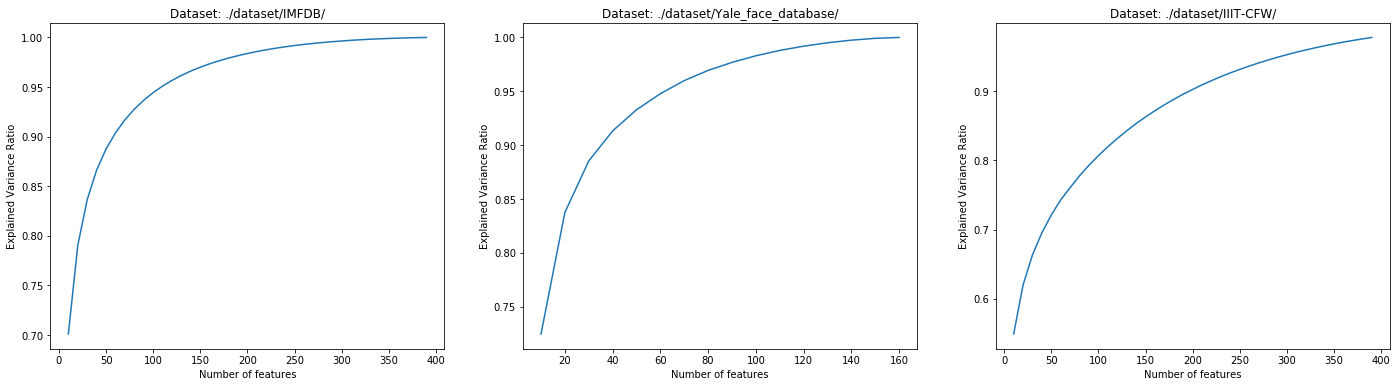

In [414]:
# Compute your features 
# eg.
# X_3D = get_kernel_lda(X,y,3)

best_feature_counts = []

fig=plt.figure(figsize=(24, 6))
i=0
for dirpath in paths:
    print('Using the {0} database'.format(dirpath))
    
    X,y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    print(X.shape)

    cumulative_sum = []
    cumulative_var = []
    test_range = []
    for feature_count in range(10, 400, 10):
        if feature_count > min(X.shape[0], X.shape[1]):
            break
        
        X_k, approximation, explained_variance = get_pca(X, feature_count)
        cumulative_sum.append(sum(explained_variance))
        cumulative_var.append(explained_variance)
        test_range.append(feature_count)
    
    cumulative_sum = np.array(cumulative_sum)
    cumulative_var = np.array(cumulative_var)
    test_range = np.array(test_range)
    
    fig.add_subplot(1, 3, i+1)
    plt.plot(test_range, cumulative_sum)
    plt.title('Dataset: {0}'.format(dirpath))
    plt.xlabel('Number of features')
    plt.ylabel('Explained Variance Ratio')
    
    optcount = (np.argmax(cumulative_sum > .95)+1)*10
    best_feature_counts.append(optcount)
    
    print("95% representation is achieved with at least {0} features".format(optcount))
    print()
    
    i+=1
    
plt.show()

As we can also see, the eigenspectrum plot for the reduced and original data is largely the same

Using the ./dataset/IMFDB/ database
Dataset shape: (400, 32, 32)


/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_feat

Using the ./dataset/Yale_face_database/ database
Dataset shape: (165, 32, 32)


/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 15 - 1) = 14 components.
  ChangedBehaviorWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_fe

Using the ./dataset/IIIT-CFW/ database
Dataset shape: (672, 32, 32)


/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_feat

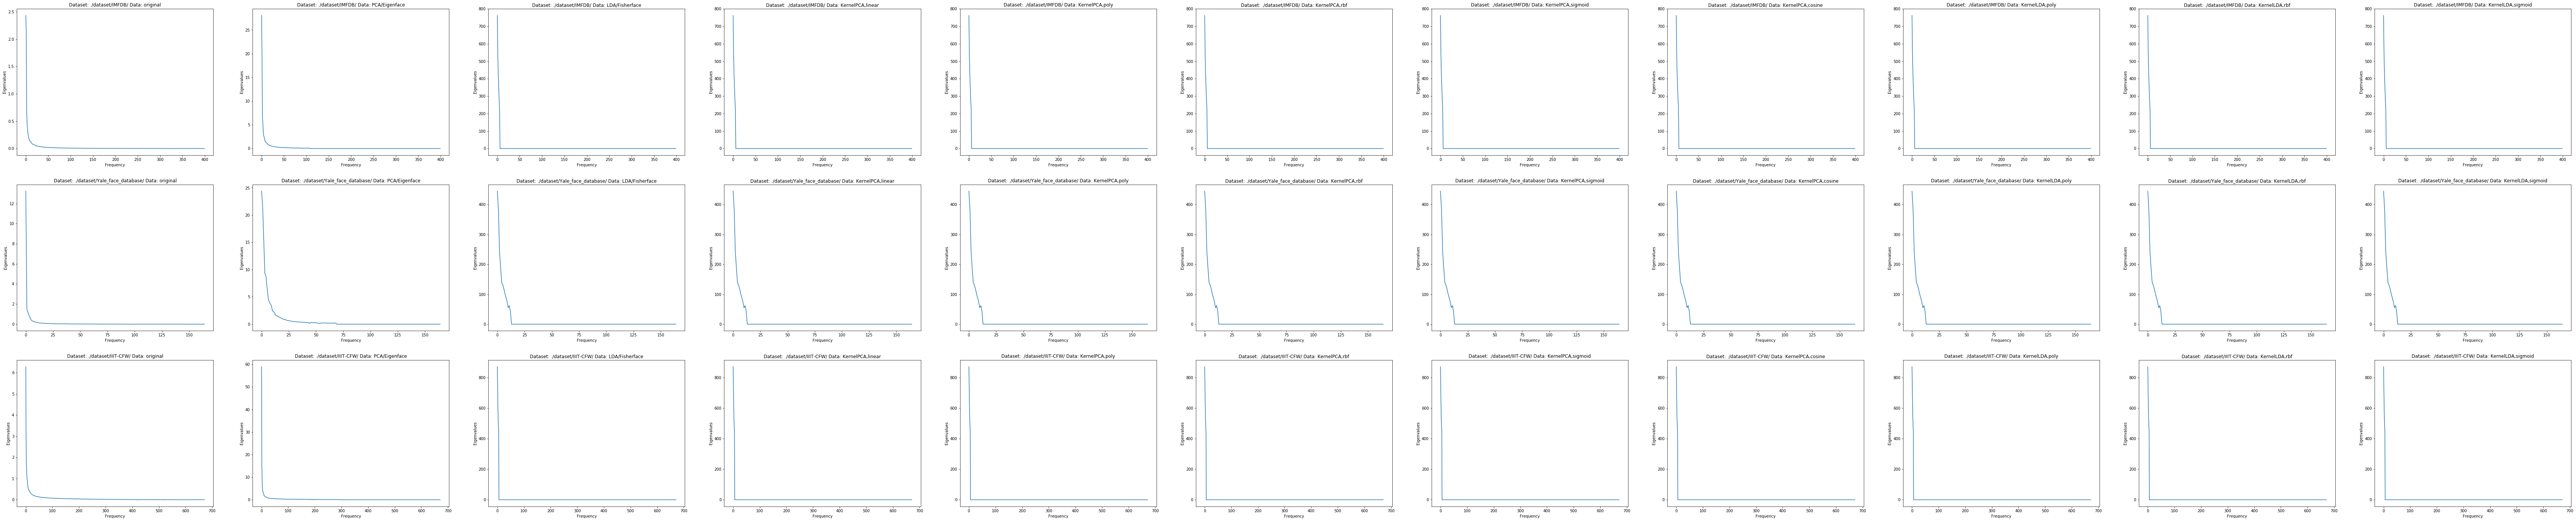

In [424]:
paths = [
    './dataset/IMFDB/',
    './dataset/Yale_face_database/',
    './dataset/IIIT-CFW/',
]

fig=plt.figure(figsize=(120, 24))
i=0
j=1
for dirpath in paths:
    print('Using the {0} database'.format(dirpath))
    
    X,y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    
    X_pca, approximation, explained_variance = get_pca(X, best_feature_counts[i])
    X_fis, lda = get_lda(X, y, best_feature_counts[i])
    X_kpca = {}
    X_klda = {}
    for kern in ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']:
        X_kpca[kern], approximation = get_kernel_pca(X, best_feature_counts[i], kernel=kern)
        if kern != 'linear' and kern != 'cosine':
            X_klda[kern] = get_kernel_lda(X, y, best_feature_counts[i], kernel=kern)
    
    fig.add_subplot(3, 11, j)
    eigval, _ = np.linalg.eig(np.cov(X))
    plt.plot(range(len(eigval)), eigval)
    plt.title('Dataset: {0} Data: {1}'.format(dirpath, 'original'))
    plt.xlabel('Frequency')
    plt.ylabel('Eigenvalues')
    j+=1
    
    fig.add_subplot(3, 11, j)
    eigval, _ = np.linalg.eig(np.cov(X_pca))
    plt.plot(range(len(eigval)), eigval)
    plt.title('Dataset: {0} Data: {1}'.format(dirpath, 'PCA/Eigenface'))
    plt.xlabel('Frequency')
    plt.ylabel('Eigenvalues')
    j+=1
    
    fig.add_subplot(3, 11, j)
    eigval, _ = np.linalg.eig(np.cov(X_fis))
    plt.plot(range(len(eigval)), eigval)
    plt.title('Dataset: {0} Data: {1}'.format(dirpath, 'LDA/Fisherface'))
    plt.xlabel('Frequency')
    plt.ylabel('Eigenvalues')
    j+=1

    for kern in ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']:
        fig.add_subplot(3, 11, j)
        eigval, _ = np.linalg.eig(np.cov(X_fis))
        plt.plot(range(len(eigval)), eigval)
        plt.title('Dataset: {0} Data: {1},{2}'.format(dirpath, 'KernelPCA', kern))
        plt.xlabel('Frequency')
        plt.ylabel('Eigenvalues')
        j+=1
        
    for kern in ['poly', 'rbf', 'sigmoid']:
        fig.add_subplot(3, 11, j)
        eigval, _ = np.linalg.eig(np.cov(X_fis))
        plt.plot(range(len(eigval)), eigval)
        plt.title('Dataset: {0} Data: {1},{2}'.format(dirpath, 'KernelLDA', kern))
        plt.xlabel('Frequency')
        plt.ylabel('Eigenvalues')
        j+=1
            
    
    
    i+=1
    
plt.show()

In [ ]:
# Plot the eigen value spectrum 

Using the ./dataset/IMFDB/ database
Dataset shape: (400, 32, 32)
(400, 1024)


/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


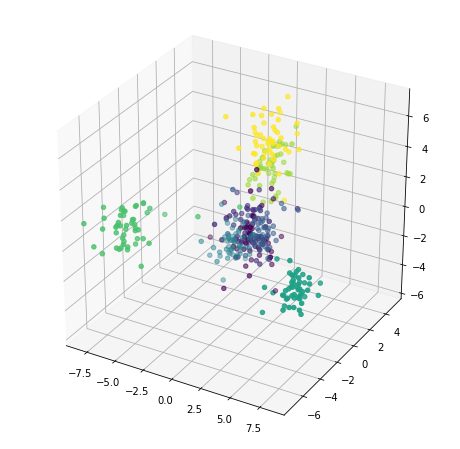

Using the ./dataset/Yale_face_database/ database
Dataset shape: (165, 32, 32)
(165, 1024)


/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


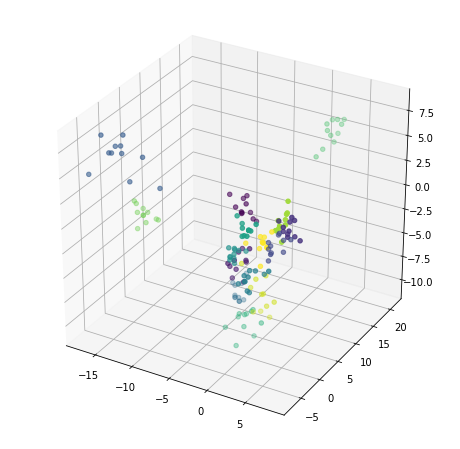

Using the ./dataset/IIIT-CFW/ database
Dataset shape: (672, 32, 32)
(672, 1024)


/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


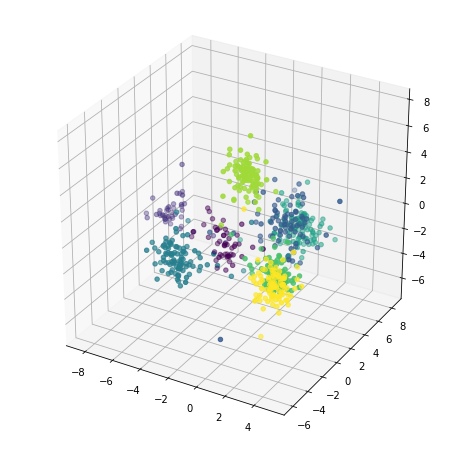

In [94]:
for dirpath in paths:
    print('Using the {0} database'.format(dirpath))
    
    X,y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    print(X.shape)

    X_3D = get_kernel_lda(X,y,3)
    
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y)
    plt.show()

1(c). Reconstruct  the  image  back for each case


In [97]:
def def_reconstruct_images(approximation, shape):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    
    reconstruct_X = approximation.reshape(shape)
    
    return reconstruct_X    

Using the ./dataset/IMFDB/ database
Dataset shape: (400, 32, 32)
(400, 1024)
400 32 32 1


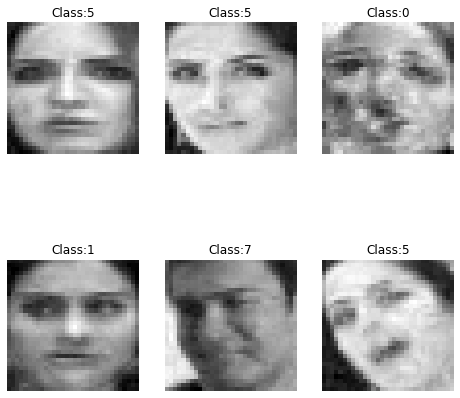

Reconstruction Error: 0.03680679323509887
Using the ./dataset/Yale_face_database/ database
Dataset shape: (165, 32, 32)
(165, 1024)
165 32 32 1


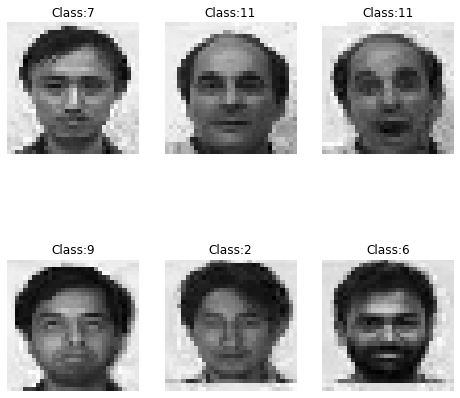

Reconstruction Error: 0.04839276902481348
Using the ./dataset/IIIT-CFW/ database
Dataset shape: (672, 32, 32)
(672, 1024)
672 32 32 1


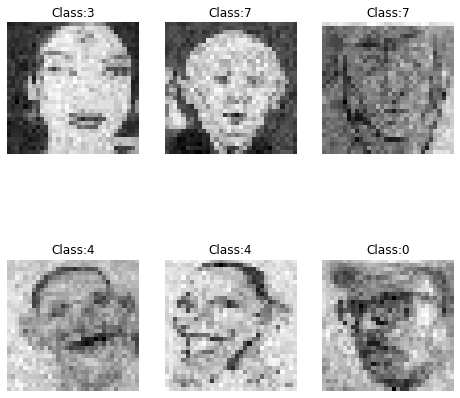

Reconstruction Error: 0.06365055335063438


In [117]:
# Display results 
i = 0
for dirpath in paths:
    print('Using the {0} database'.format(dirpath))
    
    X,y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    print(X.shape)
    print(N, H, W, C)
    
    X_k, approximation, explained_variance = get_pca(X, best_feature_counts[i])
    i += 1

    X_reconstruced = def_reconstruct_images(approximation, (N, H, W))
    
    # Display random images
    ind = np.random.randint(0,y.shape[0],6)
    disply_images(X_reconstruced[ind,...],y[ind],row=2,col=3)

    # Show the reconstruction error
    print("Reconstruction Error: {0}".format(np.sqrt(np.mean((X - X_reconstruced.reshape(N, H*W*C))**2))))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [125]:
# code goes here

errors = []

i = 0

for dirpath in paths:
    print('Using the {0} database'.format(dirpath))
    
    X,y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    print(X.shape)
#     print(N, H, W, C)
    
    X_k, approximation, explained_variance = get_pca(X, best_feature_counts[i])
    i += 1
    X_reconstruced = def_reconstruct_images(approximation, (N, H, W))
    
    tdict = {}
    
    for j in range(len(np.unique(y))):
        ind = np.where(y==j)
        error = np.sqrt(np.mean((X[ind] - X_reconstruced.reshape(N, H*W*C)[ind])**2))
        
        tdict[j] = error
        
    errors.append(tdict)
#     print(y)

pprint(errors)
for d in errors:
     print(max(d.items(), key=operator.itemgetter(1))[0])

Using the ./dataset/IMFDB/ database
Dataset shape: (400, 32, 32)
(400, 1024)
Using the ./dataset/Yale_face_database/ database
Dataset shape: (165, 32, 32)
(165, 1024)
Using the ./dataset/IIIT-CFW/ database
Dataset shape: (672, 32, 32)
(672, 1024)
[{0: 0.03519366722367522,
  1: 0.03670204799255896,
  2: 0.03802772144940505,
  3: 0.036850502251913546,
  4: 0.03739409157842132,
  5: 0.0364184626745145,
  6: 0.0376703573527466,
  7: 0.036156663567762495},
 {0: 0.05321072332268568,
  1: 0.049235502011259334,
  2: 0.044440041127683336,
  3: 0.05096478211262587,
  4: 0.0489550729956664,
  5: 0.047701160388291204,
  6: 0.04755608906147679,
  7: 0.047329290188944356,
  8: 0.0474804741173148,
  9: 0.04620268387443525,
  10: 0.04904612241766788,
  11: 0.04565120312923156,
  12: 0.04932601807199002,
  13: 0.047049430031707966,
  14: 0.05082037038448654},
 {0: 0.062038315133936615,
  1: 0.06508153966579251,
  2: 0.06404302832982849,
  3: 0.06512353545067431,
  4: 0.06483128651787196,
  5: 0.0606111

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [368]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix as con_mat
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


class Classifier():
    def __init__(self, classifier_type, max_depth=5, kernel='linear', degree=2):
#         super.__init__()
        self.classifier = LogisticRegression(
            multi_class='multinomial',
            solver = 'newton-cg'
        )
        if classifier_type == 'mlp':
            self.classifier == MLPClassifier(
                hidden_layer_sizes=(150,300,50), 
                max_iter=300,
                activation = 'relu',
                solver='adam',
                random_state=0
            )
        elif classifier_type == 'dtree':
            self.classifier = DecisionTreeClassifier(
                max_depth=max_depth,
                random_state=0
            )
        elif classifier_type == 'svm':
            self.classifier = SVC(
                kernel = kernel
            )
        elif classifier_type == 'lr':
            pass
        else:
            print('Warning: classifier_type input is wrong. Defaulting to Logistic Regression.')
            
        
        
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
            
            @return predicted classes for input X
        """
        prediction = self.classifier.predict(X)
        return prediction
        
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """
        cm = con_mat(y, pred)
        return cm
        
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.classifier.fit(X_train, y_train)
        
        
    def validate(self,X_validate,y_validate):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
            @return confusion matrix, accuracy, precision, recall, f1 score
            
        """

        pred = self.classify(X_validate)
        
        # Create a confusion matrix
        cm = self.confusion_matrix(pred, y_validate)
        
        # Calculate Validation accuracy 
        accuracy = accuracy_score(y_validate, pred)
    
        # Calculate precision and recall 
        precision = precision_score(y_validate, pred, average='micro')
        recall = recall_score(y_validate, pred, average='micro')
        
        
        # Calculate F1-score
        f1 = f1_score(y_validate, pred, average='micro')
        
#         print(classification_report(y_validate, pred))
    
        return cm, accuracy, precision, recall, f1

In [402]:
# Create a train and validation split to train your classifier 

results = []
results_pca = []
results_fis = []
# results_kpca = []



i = 0
for dirpath in paths:
    print('Using the {0} database'.format(dirpath))
    
    X,y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    X = X.reshape((N,H*W*C))
    
    X_pca, approximation, explained_variance = get_pca(X, best_feature_counts[i])
    X_fis, lda = get_lda(X, y, best_feature_counts[i])
    X_kpca = {}
    X_klda = {}
#     for kern in ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']:
#         X_kpca[kern], approximation = get_kernel_pca(X, best_feature_counts[i], kernel=kern)
        
#         if kern != 'linear' and kern != 'cosine':
#             X_klda[kern] = get_kernel_lda(X, y, best_feature_counts[i], kernel=kern)
    
    
    print('Regular, ', end='')
    results = trainsequence(X, y, results)
    print('PCA, ', end='')
    results_pca = trainsequence(X_pca, y, results_pca)
    print('Fisher, ', end='')
    results_fis = trainsequence(X_fis, y, results_fis)
    
    print()

Using the ./dataset/IMFDB/ database
Dataset shape: (400, 32, 32)
Regular, 

/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


PCA, Fisher, 
Using the ./dataset/Yale_face_database/ database
Dataset shape: (165, 32, 32)
Regular, 

/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 15 - 1) = 14 components.
  ChangedBehaviorWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


PCA, Fisher, 
Using the ./dataset/IIIT-CFW/ database
Dataset shape: (672, 32, 32)


/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:466: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(1024, 8 - 1) = 7 components.
  ChangedBehaviorWarning)
/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:472: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


Regular, PCA, Fisher, 


/home/zubair/anaconda3/envs/SMAI/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [396]:
def trainsequence(X, y, results):
    tdict = {}
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    lr = Classifier('lr')
    dtree = Classifier('dtree', max_depth=12)
    svm = Classifier('svm', kernel='linear', degree=2)
    mlp = Classifier('mlp')
    
#     print('Testing Logistic Regression')
    lr.train(X_train, y_train)
    cm, accuracy, precision, recall, f1 = lr.validate(X_test, y_test)
    tdict['lr'] = cm, accuracy, precision, recall, f1
    
#     print('Testing Decision Tree')
    dtree.train(X_train, y_train)
    cm, accuracy, precision, recall, f1 = dtree.validate(X_test, y_test)
    tdict['dtree'] = cm, accuracy, precision, recall, f1
    
#     print('Testing Support Vectors')
    svm.train(X_train, y_train)
    cm, accuracy, precision, recall, f1 = svm.validate(X_test, y_test)
    tdict['svm'] = cm, accuracy, precision, recall, f1
    
#     print('Testing MLP')
    mlp.train(X_train, y_train)
    cm, accuracy, precision, recall, f1 = mlp.validate(X_test, y_test)
    tdict['mlp'] = cm, accuracy, precision, recall, f1
    results.append(tdict)
    
    return results

In [425]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Print the table. (You can use Pandas)

datanames = ['IMFDB', 'Yale face database', 'IIIT-CFW']
tables = []

for i in range(3):
    print("Dataset: {0}".format(datanames[i]))
    tdict = {}
    tdict['PCA/Eigenface + LR'] = results_pca[0]['lr'][1:]
    tdict['PCA/Eigenface + DTree'] = results_pca[0]['dtree'][1:]
    tdict['PCA/Eigenface + SVC'] = results_pca[0]['svm'][1:]
    tdict['PCA/Eigenface + MLP'] = results_pca[0]['mlp'][1:]
    tdict['LDA/Fisherface + LR'] = results_fis[0]['lr'][1:]
    tdict['LDA/Fisherface + DTree'] = results_fis[0]['dtree'][1:]
    tdict['LDA/Fisherface + SVC'] = results_fis[0]['svm'][1:]
    tdict['LDA/Fisherface + MLP'] = results_fis[0]['mlp'][1:]

    tables.append(pd.DataFrame.from_dict(tdict, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1 Score']))
    print(tables[i])
    print()

Dataset: IMFDB
                        Accuracy  Precision  Recall  F1 Score
PCA/Eigenface + LR        0.7000     0.7000  0.7000    0.7000
PCA/Eigenface + DTree     0.3625     0.3625  0.3625    0.3625
PCA/Eigenface + SVC       0.6375     0.6375  0.6375    0.6375
PCA/Eigenface + MLP       0.7000     0.7000  0.7000    0.7000
LDA/Fisherface + LR       0.9500     0.9500  0.9500    0.9500
LDA/Fisherface + DTree    0.9000     0.9000  0.9000    0.9000
LDA/Fisherface + SVC      0.9375     0.9375  0.9375    0.9375
LDA/Fisherface + MLP      0.9500     0.9500  0.9500    0.9500

Dataset: Yale face database
                        Accuracy  Precision  Recall  F1 Score
PCA/Eigenface + LR        0.7000     0.7000  0.7000    0.7000
PCA/Eigenface + DTree     0.3625     0.3625  0.3625    0.3625
PCA/Eigenface + SVC       0.6375     0.6375  0.6375    0.6375
PCA/Eigenface + MLP       0.7000     0.7000  0.7000    0.7000
LDA/Fisherface + LR       0.9500     0.9500  0.9500    0.9500
LDA/Fisherface + DTree    

In [ ]:
# For each dataset print the confusion matrix for the best model 

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

In [ ]:
# Compute TSNE for different features and create a scatter plot

X =  # feature 
k = 3 # Number of components in TSNE

# Compute
X_TSNE = TSNE(n_components=k).fit_transform(X)


# Plot the representation in 2d/3d


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [ ]:
class FaceVerification():
    def __init__():
        super.__init__()
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,X,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        
        return verfication_results
        
    def train(self,X_train,y_train):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        
    def validate(self,X_validate,y_validate):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        return 

In [ ]:
# Create a train and validation split and show your results 

In [ ]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [ ]:
# Load data

In [ ]:
# Define your features

In [ ]:
# Create your classifier

# Validate your classifier

In [ ]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.  

In [ ]:
# Show quantitative results such as examples of correct prediction and wrong prediction